<a href="https://colab.research.google.com/github/shemaaali/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment/SDA2_LS_DS18_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [164]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [165]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
print(df.shape)
df.head()

(48817, 34)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
# Wrangle data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', 
                 parse_dates=['created'],
                 index_col='created')
print(df.shape)
df.head()

(49352, 33)


,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [167]:
# Creating some feature engineering from the pre-existing columns
# Sale price
df['sale_price'] = df['price'] / df['bedrooms']
df['sale_price'] 

created
2016-06-24 07:54:24    1000.0
2016-06-12 12:19:27    2732.5
2016-04-17 03:26:41    2850.0
2016-04-18 02:22:02    3275.0
2016-04-28 01:32:41     837.5
                        ...  
2016-06-02 05:41:05    1600.0
2016-04-04 18:22:34    3950.0
2016-04-16 02:13:40    2595.0
2016-04-08 02:13:33       inf
2016-04-12 02:48:07    1100.0
Name: sale_price, Length: 49352, dtype: float64

In [168]:
# Total numbers of rooms in apartment
df['total_num_rooms'] = df['bedrooms'] + df['bathrooms'] 
df['total_num_rooms']

created
2016-06-24 07:54:24    4.5
2016-06-12 12:19:27    3.0
2016-04-17 03:26:41    2.0
2016-04-18 02:22:02    2.0
2016-04-28 01:32:41    5.0
                      ... 
2016-06-02 05:41:05    3.0
2016-04-04 18:22:34    2.0
2016-04-16 02:13:40    2.0
2016-04-08 02:13:33    1.0
2016-04-12 02:48:07    3.0
Name: total_num_rooms, Length: 49352, dtype: float64

In [169]:
# Ratio of beds to baths
df['ratio_beds_baths'] = df['bedrooms'] / df['bathrooms'] 
df['ratio_beds_baths']

created
2016-06-24 07:54:24    2.0
2016-06-12 12:19:27    2.0
2016-04-17 03:26:41    1.0
2016-04-18 02:22:02    1.0
2016-04-28 01:32:41    4.0
                      ... 
2016-06-02 05:41:05    2.0
2016-04-04 18:22:34    1.0
2016-04-16 02:13:40    1.0
2016-04-08 02:13:33    0.0
2016-04-12 02:48:07    2.0
Name: ratio_beds_baths, Length: 49352, dtype: float64

In [170]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,sale_price,total_num_rooms,ratio_beds_baths
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000.0,4.5,2.0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2732.5,3.0,2.0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2850.0,2.0,1.0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3275.0,2.0,1.0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,837.5,5.0,4.0


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49352 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             49352 non-null  float64
 1   bedrooms              49352 non-null  int64  
 2   description           47906 non-null  object 
 3   display_address       49217 non-null  object 
 4   latitude              49352 non-null  float64
 5   longitude             49352 non-null  float64
 6   price                 49352 non-null  int64  
 7   street_address        49342 non-null  object 
 8   interest_level        49352 non-null  object 
 9   elevator              49352 non-null  int64  
 10  cats_allowed          49352 non-null  int64  
 11  hardwood_floors       49352 non-null  int64  
 12  dogs_allowed          49352 non-null  int64  
 13  doorman               49352 non-null  int64  
 14  dishwasher            49352 non-nul

In [172]:
df.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,sale_price,total_num_rooms,ratio_beds_baths
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.00000,49352.0,49352.000000,49195.0
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03,0.525126,0.476982,0.476759,0.446486,0.424887,0.413965,0.365983,0.052541,0.268520,0.185423,0.177055,0.132821,0.138677,0.104089,0.087190,0.060686,0.055357,0.051852,0.046847,0.043929,0.042612,0.039370,0.027517,0.02620,inf,2.753820,inf
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04,0.499373,0.499475,0.499465,0.497133,0.494331,0.492547,0.481710,0.223117,0.443194,0.388644,0.381719,0.339385,0.345613,0.305379,0.282116,0.238757,0.228679,0.221730,0.211313,0.204940,0.201983,0.194476,0.163585,0.15973,NaN,1.446091,NaN
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,205.0,0.000000,0.0
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1600.0,2.000000,1.0
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2450.0,2.000000,1.0
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,4000.0,4.000000,2.0
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,inf,13.500000,inf


In [173]:
df.dtypes

bathrooms               float64
bedrooms                  int64
description              object
display_address          object
latitude                float64
longitude               float64
price                     int64
street_address           object
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_patio              int64
wheelcha

##  EDA

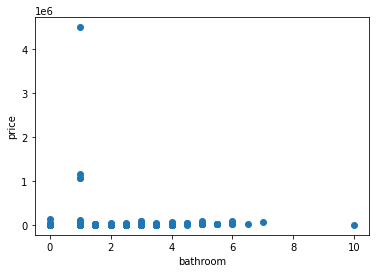

In [174]:
plt.scatter(df['bathrooms'], df['price']);
plt.xlabel('bathroom')
plt.ylabel('price')
plt.show();

## Split the Data

In [175]:
# Split my feature matrix from my target vector
# Target
y = df['price']
# Feature Matrix
X = df[['bathrooms', 'longitude']]

## Train-validation split

In [179]:
# Split my dataset into training and validation sets
# Train on 2016-04-17 03:26:41. Validation on 2016-06-03 03:21:22	.

cutoff_date = '2016-04-17 03:26:41'
mask = X.index > '2016-04-17 03:26:41'	
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

## Baseline

In [180]:
def baseline_predict(X=None):
  return y_train.mean()

baseline_predict()

3873.0949337297166

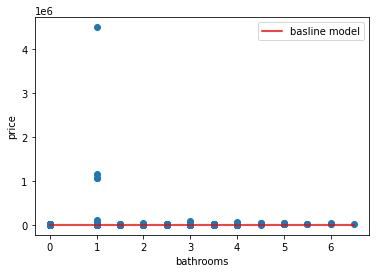

In [181]:
import numpy as np

my_tools =  'bathrooms'
x_min, x_max = X_train[my_tools].min(), X_train[my_tools].max()
x_coords = np.linspace(x_min, x_max, 50)
y_pred = [baseline_predict(x) for x in x_coords]
plt.plot(x_coords, y_pred, color='red', label='basline model')

plt.scatter(X_train[my_tools], y_train)
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.legend()
plt.show();

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

baseline_mae = mean_absolute_error(y_train, [y_train.mean()]*len(y_train))
baseline_rmse = mean_squared_error(y_train, [y_train.mean()]*len(y_train), squared=False)

print('Baseline MAE:', baseline_mae)
print('Baseline RMSE:', baseline_rmse)

Baseline MAE: 1594.8206368908977
Baseline RMSE: 24354.45562545473


## Build Model

In [183]:
# 1. Arrange X features matrix and y target vector
# Target
y = df['price']
# Feature Matrix
X = df[['bathrooms', 'longitude']]

In [ ]:
# 2. Creating a train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
# Start with multiple features
# 3. Import our predictor estimtor class from Scikit-learn
from sklearn.linear_model import LinearRegression

In [185]:
# 4. Instantiate our prediction
mlr = LinearRegression()

In [186]:
# 5. Fit our model to the training data
mlr.fit(X_train, y_train);

In [192]:
mlr.coef_

array([3000.68663753,  -13.60843956])

In [193]:
mlr.intercept_

-776.7656138994921

In [187]:
# 6. Apply the model to the new data which is testing data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [188]:
# Checking our metrics for the TRAINING DATA
y_pred = mlr.predict(X_train)

model_mae = mean_absolute_error(y_train, y_pred)
model_rmse = mean_squared_error(y_train, y_pred, squared=False)
model_r2 = r2_score(y_train, y_pred)

print('Model MAE (training data):', model_mae)
print('Model RMSE (training data):', model_rmse)
print('Model R^2 (training data):', model_r2)

Model MAE (training data): 1206.9114059047524
Model RMSE (training data): 24307.75020623498
Model R^2 (training data): 0.003831794526852339


In [189]:
# Checking our metrics for the VALIDATION DATA
y_pred = mlr.predict(X_val)

model_mae = mean_absolute_error(y_val, y_pred)
model_rmse = mean_squared_error(y_val, y_pred, squared=False)
model_r2 = r2_score(y_val, y_pred)

print('Model MAE (validation data):', model_mae)
print('Model RMSE (validation data):', model_rmse)
print('Model R^2 (validation data):', model_r2)

Model MAE (validation data): 1064.5001297252415
Model RMSE (validation data): 2678.022868286688
Model R^2 (validation data): 0.2743047386061592
